In [112]:
import cv2
from matplotlib import pyplot
import numpy as np
from skimage.morphology import skeletonize

In [113]:
img1 = cv2.cvtColor(cv2.imread("maps/test1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("maps/test2.png"), cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread("maps/test3.png"), cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(cv2.imread("maps/test4.png"), cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(cv2.imread("maps/test5.jpg"), cv2.COLOR_BGR2RGB)
img6 = cv2.cvtColor(cv2.imread("maps/test6.png"), cv2.COLOR_BGR2RGB)

img_pre = [
            img1, 
            img2, 
            img3, 
            img4, 
            img5, 
            img6
            ]

In [118]:
def segmentation(img, blur_kernel_shape=(3,3), k_means=3):
    """
    Performs image segmentation using k-means clustering.

    Parameters:
        img (numpy.ndarray): Input image.
        blur_kernel_shape (tuple): Kernel shape for Gaussian blur (default: (3, 3)).
        k_means (int): Number of clusters for k-means clustering (default: 3).

    Returns:
        numpy.ndarray: Segmented image.

    """
    # Reshape the image into a 2D array of pixel values
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define criteria for k-means clustering and perform function
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k_means, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Assign the segmented colors based on the labels
    centers = np.uint8(centers)
    labels = labels.flatten()
    segmented_image = centers[labels.flatten()]

    # Reshape image to input shape
    segmented_image = segmented_image.reshape(img.shape)

    # Apply Gaussian blur with given kerenal shape
    out = cv2.GaussianBlur(segmented_image, blur_kernel_shape, 0)

    return out


def morfOpen(img, kernel_shape=(5,5)):
    """
    Performs morphological opening on a binary image.

    Parameters:
        img (numpy.ndarray): Input binary image.
        kernel_shape (tuple): Kernel shape for morphological opening (default: (5, 5)).

    Returns:
        numpy.ndarray: Output image after morphological opening.

    """
    kernel = np.ones(kernel_shape,np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)


def morfClose(img, kernel_shape=(3,3)):
    """
    Performs morphological closing on a binary image.

    Parameters:
        img (numpy.ndarray): Input binary image.
        kernel_shape (tuple): Kernel shape for morphological closing (default: (3, 3)).

    Returns:
        numpy.ndarray: Output image after morphological closing.

    """
    kernel = np.ones(kernel_shape,np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)


def binarization(img):
    """
    Converts an input image to a binary image using Otsu's thresholding.

    Parameters:
        img (numpy.ndarray): Input image.

    Returns:
        numpy.ndarray: Binary image.

    """
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, binary_image = cv2.threshold(gray_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return binary_image


def remove_branches(img_skt, TOL=0.05):
    """
    Removes small branches from a skeletonized image.

    Parameters:
        img_skt (numpy.ndarray): Binary skeletonized image.
        TOL (float): Threshold value to determine small branches (default: 0.05).

    Returns:
        numpy.ndarray: Filtered skeletonized image.

    """
    # Invert the skeletonized image
    img_skt_rev = cv2.bitwise_not(img_skt)

    # Seraching isolated elements on binary photo with connectedComponentsWithStats
    # connectivity = 4 -> two pixels are connected if are horizontally or vertically adjacent
    # connectivity = 8 -> same as with 4 but including corners
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(img_skt_rev, connectivity=8)
    
    # Calculating lenght of each element
    lengths = [stats[i, cv2.CC_STAT_AREA] for i in range(1, num_labels)]
    
    # Sorting all elemnts by lenght 
    sorted_labels = sorted(range(1, num_labels), key=lambda x: lengths[x - 1], reverse=True)
    
    # To delete noises we keep only elements wtih lenght >= TOL
    longest_length = lengths[sorted_labels[0] - 1]
    num_components = sum(length >= TOL * longest_length for length in lengths)
    
    # Creating mask with only the longest elements
    mask = np.zeros_like(img_skt)
    for i in range(num_components):
        component_label = sorted_labels[i]
        mask[labels == component_label] = 255
    
    # Applying mask
    img_skt_filtered = cv2.bitwise_and(img_skt_rev, mask)
    return img_skt_filtered



In [115]:
img_post = []

for i in range(len(img_pre)):
    temp = segmentation(img_pre[i])
    temp = binarization(temp)
    temp = morfClose(temp)
    img_post.append(temp)

In [116]:
img_skt = []
for i in range(len(img_post)):
    temp = skeletonize(img_post[i] / 255)
    temp = (temp.astype(np.uint8) ^ 1) * 255
    img_skt.append(temp)

In [119]:
img_skt_filtered = []
for skt in img_skt:
    skt_filtered = remove_branches(skt, TOL=0.05)
    img_skt_filtered.append(skt_filtered)

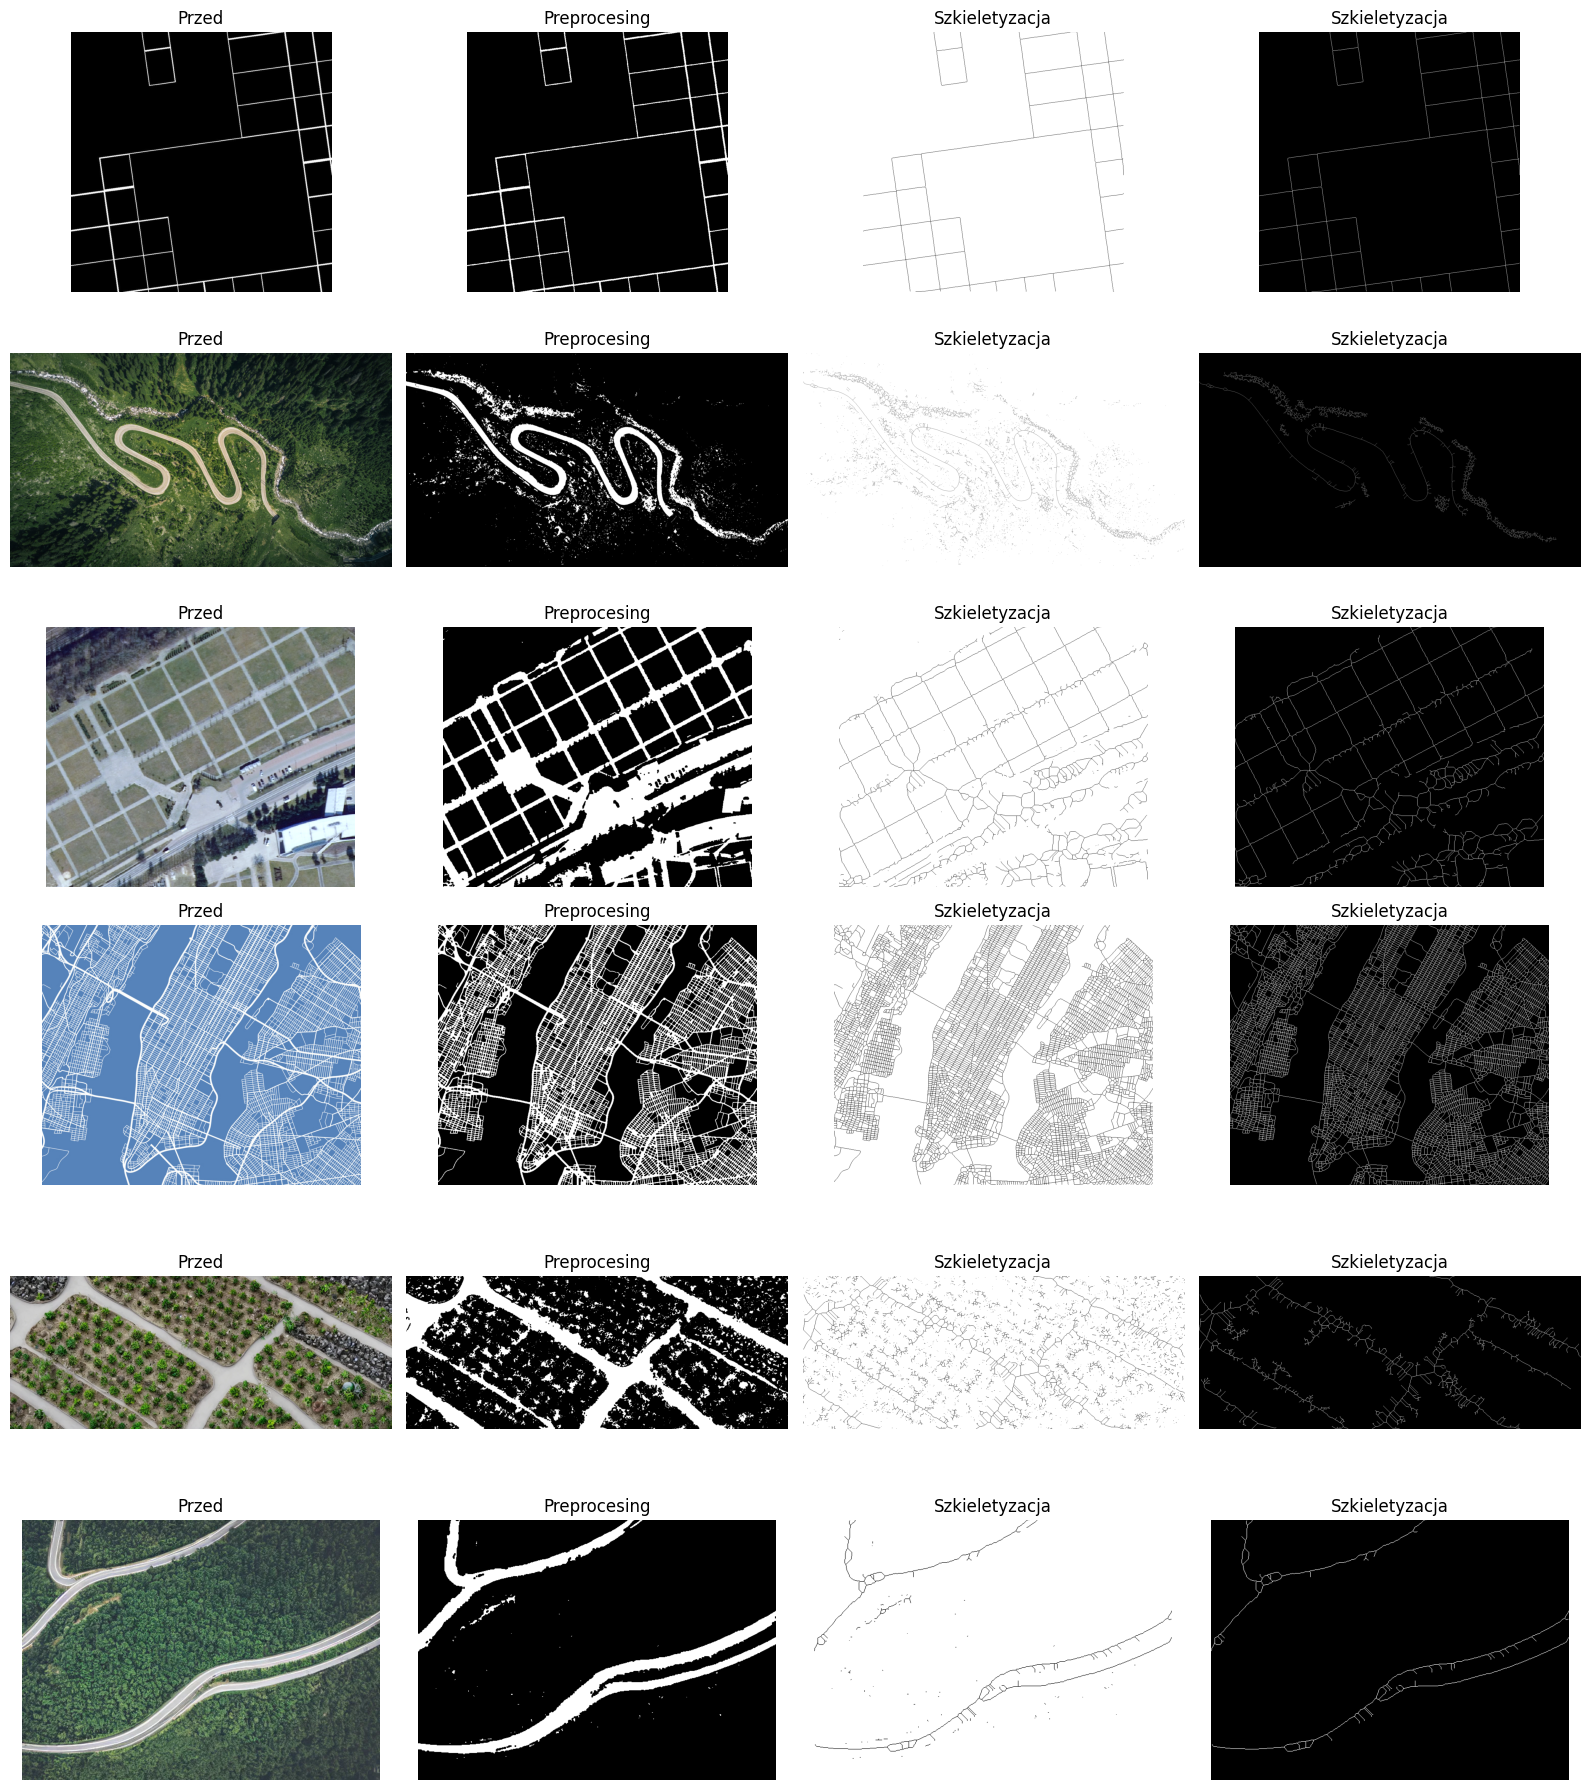

In [120]:
fig, axes = pyplot.subplots(len(img_pre), 4, figsize=(16, 3*len(img_pre)))

for i in range(len(img_pre)):
  
    axes[i, 0].imshow(img_pre[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Przed')

    axes[i, 1].imshow(img_post[i], cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Preprocesing')

    axes[i, 2].imshow(img_skt[i], cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Szkieletyzacja')

    axes[i, 3].imshow(img_skt_filtered[i], cmap='gray')
    axes[i, 3].axis('off')
    axes[i, 3].set_title('Czyszczenie')

pyplot.tight_layout()
pyplot.savefig('output.png')
pyplot.show()